### 国籍分类

In [210]:
# 打印出所有文件
from io import open
import glob
import os
import matplotlib.pyplot as plt


#  glob.glob()返回的是列表 list类型。是所有路径下的符合条件的文件名的列表。
def find_files(path): 
    return glob.glob(path)

print(find_files(r'C:\Users\asus\Desktop\lesson\07seventh_lesson\assignment-07数据集\data\names/*.txt'))


['C:\\Users\\asus\\Desktop\\lesson\\07seventh_lesson\\assignment-07数据集\\data\\names\\Arabic.txt', 'C:\\Users\\asus\\Desktop\\lesson\\07seventh_lesson\\assignment-07数据集\\data\\names\\Chinese.txt', 'C:\\Users\\asus\\Desktop\\lesson\\07seventh_lesson\\assignment-07数据集\\data\\names\\Czech.txt', 'C:\\Users\\asus\\Desktop\\lesson\\07seventh_lesson\\assignment-07数据集\\data\\names\\Dutch.txt', 'C:\\Users\\asus\\Desktop\\lesson\\07seventh_lesson\\assignment-07数据集\\data\\names\\English.txt', 'C:\\Users\\asus\\Desktop\\lesson\\07seventh_lesson\\assignment-07数据集\\data\\names\\French.txt', 'C:\\Users\\asus\\Desktop\\lesson\\07seventh_lesson\\assignment-07数据集\\data\\names\\German.txt', 'C:\\Users\\asus\\Desktop\\lesson\\07seventh_lesson\\assignment-07数据集\\data\\names\\Greek.txt', 'C:\\Users\\asus\\Desktop\\lesson\\07seventh_lesson\\assignment-07数据集\\data\\names\\Irish.txt', 'C:\\Users\\asus\\Desktop\\lesson\\07seventh_lesson\\assignment-07数据集\\data\\names\\Italian.txt', 'C:\\Users\\asus\\Desktop\\les

In [211]:
# 转换成ASCII码
import unicodedata
import string

all_letters = string.ascii_letters + " .,;'"
# ascii_letters是生成所有字母，从a-z，小写26+大写26
n_letters = len(all_letters) 

# normalize() 第一个参数指定字符串标准化的方式，这里为NFD
# unicodedata.category():把一个字符返回它在UNICODE里分类的类型 
# [Mn] Mark, Nonspacing
def unicode_2_Ascii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicode_2_Ascii('Ślusàrski'))

Slusarski


In [212]:
# 建立类别和对于的名字的dictionary对应
category_lines = {}
all_categories = []
# 读取文件 按行划分
def read_lines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicode_2_Ascii(line) for line in lines]

# os.path.splitext(“文件路径”)    分离文件名与扩展名
# os.path.basename(filename)获取对应路径下文件的名字
for filename in find_files(r'C:\Users\asus\Desktop\lesson\07seventh_lesson\assignment-07数据集\data\names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
#     print(category)
    all_categories.append(category)
    lines = read_lines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

In [213]:
n_categories

18

In [214]:
category_lines['Chinese'][:10]

['Ang', 'AuYong', 'Bai', 'Ban', 'Bao', 'Bei', 'Bian', 'Bui', 'Cai', 'Cao']

In [215]:
# pytorch向量化
import torch

# 获取letter在all_letters中索引
def letter_to_index(letter):
    return all_letters.find(letter)

# 将letter转为 1*n_letters 的tensor表示一个字母，一个one-hot向量所有位置都填充为0，并在其表示的字母的位置表示为1
def letter_to_tensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letter_to_index(letter)] = 1
    return tensor

# 将line转为 len(line)*1*n_letters 的tensor表示一个单词
def line_to_tensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letter_to_index(letter)] = 1
    return tensor

print(letter_to_index('J'))
print(line_to_tensor('Jones').size())


35
torch.Size([5, 1, 57])


In [216]:
line_to_tensor('Jones')

tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0

In [217]:
# 构建rnn
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        # 对继承自父类的属性进行初始化
        super(RNN, self).__init__()
        
        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        # torch.cat是将两个张量（tensor）拼接在一起，0为行，1为列
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128

In [218]:
rnn = RNN(n_letters, n_hidden, n_categories)

In [219]:
input = letter_to_tensor('A')
hidden =torch.zeros(1, n_hidden)

output, next_hidden = rnn.forward(input, hidden)

In [220]:
output

tensor([[-2.8530, -2.8828, -2.9146, -2.8778, -2.8501, -2.9002, -2.9111, -2.9453,
         -2.9233, -2.8849, -2.7915, -2.9208, -2.9789, -2.9209, -2.8907, -2.9067,
         -2.8103, -2.8812]], grad_fn=<LogSoftmaxBackward>)

In [221]:
next_hidden

tensor([[-0.1153,  0.0792,  0.0202,  0.0989, -0.0112, -0.0385,  0.0393, -0.0924,
          0.0807,  0.0206, -0.1031,  0.0019, -0.0828, -0.0689, -0.0445,  0.0106,
         -0.1231,  0.0907, -0.0643, -0.1129, -0.0826,  0.0134, -0.0727, -0.0124,
          0.0649, -0.1153,  0.0570,  0.0222, -0.0014,  0.0907, -0.0737, -0.0820,
         -0.0472, -0.0624,  0.0400,  0.1157, -0.0315,  0.0489,  0.0982,  0.0497,
          0.0032,  0.0628, -0.0736, -0.0168,  0.0558, -0.0730,  0.0880,  0.0450,
          0.0437,  0.0024,  0.0165,  0.0076,  0.0763,  0.1043,  0.0239, -0.0278,
          0.0008,  0.1198,  0.0728, -0.1001, -0.1148, -0.0146, -0.1343, -0.0683,
         -0.0126,  0.0519,  0.0443, -0.0063, -0.0999,  0.0379,  0.1108, -0.0681,
          0.0394,  0.0410,  0.0364, -0.0338, -0.0159,  0.0105, -0.0977, -0.0221,
          0.0473,  0.0470,  0.0222, -0.0153,  0.0829, -0.0498, -0.0952, -0.0658,
         -0.0609, -0.1410,  0.0818, -0.0505,  0.0140, -0.0709, -0.0940,  0.0535,
          0.1138,  0.1173, -

In [222]:
input = line_to_tensor('Albert')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn.forward(input[0], hidden)
print(output)

tensor([[-2.8530, -2.8828, -2.9146, -2.8778, -2.8501, -2.9002, -2.9111, -2.9453,
         -2.9233, -2.8849, -2.7915, -2.9208, -2.9789, -2.9209, -2.8907, -2.9067,
         -2.8103, -2.8812]], grad_fn=<LogSoftmaxBackward>)


In [223]:
def category_from_output(output):
    # topk(1)函数取指定维度上的最大值，第二个参数dim=1，为按行取，dim=0，为按列取，默认最后一个维度
    top_n, top_i = output.topk(1)
    # 一个元素张量可以用item得到元素值
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

In [224]:
print(category_from_output(output))

('Japanese', 10)


In [225]:
# 随机生成训练数据
import random

# random.randint(a,b)，生成的随机数n: a <= n <= b
def sample(l):
    return l[random.randint(0, len(l) - 1)]

def sample_trainning():
    category = sample(all_categories)
    line = sample(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = line_to_tensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = sample_trainning()
    print('category =', category, '/ line =', line)

category = Chinese / line = Han
category = French / line = Martel
category = Czech / line = Trampota
category = Japanese / line = Kuwabara
category = Czech / line = Kulhanek
category = French / line = Arthur
category = Irish / line = Callaghan
category = Greek / line = Haritopoulos
category = Scottish / line = White
category = Korean / line = Moon


In [226]:
criterion = nn.CrossEntropyLoss()

In [227]:
learning_rate = 0.005 
# 学习率过大会爆炸，过小会消失

def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()
    
    # 梯度置零
    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn.forward(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(-learning_rate, p.grad.data)

    return output, loss.item()

In [228]:
import time
import math

n_iters = 10000 # 这个数字你可以调大一些
print_every = 1000
plot_every = 500


# 记录损失用于绘图
current_loss = 0
all_losses = []

# 运行时间
def time_since(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = sample_trainning()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = category_from_output(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, time_since(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

1000 10% (0m 2s) 2.8254 Do / Scottish ✗ (Vietnamese)
2000 20% (0m 5s) 2.8622 Bui / Japanese ✗ (Vietnamese)
3000 30% (0m 7s) 3.0070 Cunningham / Japanese ✗ (Scottish)
4000 40% (0m 10s) 1.3697 Frangopoulos / Greek ✓
5000 50% (0m 13s) 2.8636 Krebs / Greek ✗ (German)
6000 60% (0m 15s) 1.7311 Yoo / Korean ✓
7000 70% (0m 18s) 2.5471 Seghers / Portuguese ✗ (Dutch)
8000 80% (0m 21s) 1.8991 Vo / Chinese ✗ (Vietnamese)
9000 90% (0m 24s) 2.4684 Bedford / French ✗ (English)
10000 100% (0m 26s) 1.7464 Esteves / Portuguese ✓


In [229]:
all_losses

[2.8800274057388306,
 2.8606297698020935,
 2.8368014006614684,
 2.809642644405365,
 2.7899490394592283,
 2.739898540496826,
 2.70212452173233,
 2.6553794884681703,
 2.574598779261112,
 2.521230458974838,
 2.4623934410214425,
 2.3534689715504644,
 2.3847903265953065,
 2.3168485907316207,
 2.328825580120087,
 2.3035310208797455,
 2.2697849564552306,
 2.2593431421518324,
 2.1559461755156515,
 2.1866892353892324]

In [230]:
%matplotlib inline

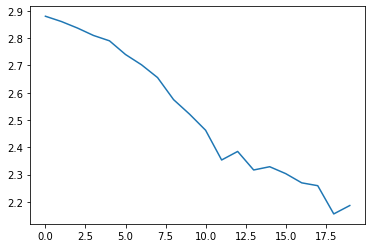

In [231]:
plt.plot(all_losses)

In [232]:
def evaluate(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(line_to_tensor(input_line))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

predict('Dovesky')
predict('Jackson')
predict('Satoshi')


> Dovesky
(-1.70) Polish
(-1.98) Russian
(-2.36) English

> Jackson
(-1.92) Russian
(-2.20) Irish
(-2.21) English

> Satoshi
(-1.95) Japanese
(-2.09) Italian
(-2.13) Polish


### 1.两层layersrnn

In [233]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h1 = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o1 = nn.Linear(input_size + hidden_size, output_size)
        
        self.i2h2 = nn.Linear(hidden_size, hidden_size)
        self.i2o2 = nn.Linear(output_size, output_size)
        
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden1 = self.i2h1(combined)
        output1 = self.i2o1(combined)
        
        hidden2 = self.i2h2(hidden1)
        output2 = self.i2o2(output1)
        output = self.softmax(output2)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128

In [234]:
twolayers_rnn = RNN(n_letters,n_hidden,n_categories)

In [235]:
learning_rate = 0.005 
# 学习率过大会爆炸，过小会消失

def train(category_tensor, line_tensor):
    hidden = twolayers_rnn.initHidden()
    
    # 梯度置零
    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = twolayers_rnn.forward(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(-learning_rate, p.grad.data)

    return output, loss.item()

In [236]:
import time
import math

n_iters = 10000 # 这个数字你可以调大一些
print_every = 1000
plot_every = 500


# Keep track of losses for plotting
current_loss = 0
all_losses = []

def time_since(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = sample_trainning()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = category_from_output(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, time_since(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

1000 10% (0m 2s) 3.0563 Tempest / Czech ✗ (English)
2000 20% (0m 4s) 2.9726 Tieu / Czech ✗ (Vietnamese)
3000 30% (0m 6s) 2.9534 Inoue / Czech ✗ (Japanese)
4000 40% (0m 7s) 2.6661 Sula / Czech ✓
5000 50% (0m 9s) 3.0392 Holzmann / Spanish ✗ (German)
6000 60% (0m 11s) 3.0173 Demarchis / Czech ✗ (Greek)
7000 70% (0m 13s) 2.9557 Krol / Spanish ✗ (Polish)
8000 80% (0m 15s) 3.0018 Rothbauer / Czech ✗ (German)
9000 90% (0m 17s) 2.7473 Ferro / Spanish ✗ (Portuguese)
10000 100% (0m 19s) 2.7069 Costa / Czech ✗ (Spanish)


In [237]:
%matplotlib inline

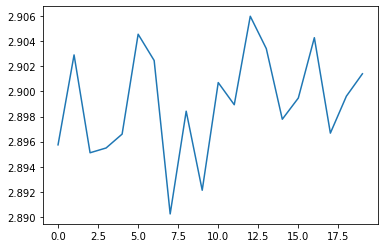

In [238]:
plt.plot(all_losses)

### 结果对比 

单层layer与多层layers对比，耗时未增加，loss明显增加，并且波动更大。

### 2.1 原始的RNN模型改成nn.LSTM

In [240]:
lstm = nn.LSTM(n_letters, n_hidden, num_layers=1)

In [241]:
criterion = nn.CrossEntropyLoss()

In [274]:
learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn

def train(category_tensor, line_tensor):

    lstm.zero_grad()
    h0 = torch.randn(1, 1, 128)
    c0 = torch.randn(1, 1, 128)
    output, hidden = lstm(line_tensor, (h0,c0))
    
    for i in range(output.size()[0]):
#         output, hidden = lstm(output[i], (h0,c0))
        output_1 = output[i]
        output_2 = i2o(output_1)
        output_3 = softmax(output_2)

    loss = criterion(output_3, category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(-learning_rate, p.grad.data)

    return output_3, loss.item()

In [275]:
import time
import math

n_iters = 10000 # 这个数字你可以调大一些
print_every = 1000
plot_every = 500


# Keep track of losses for plotting
current_loss = 0
all_losses = []

def time_since(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = sample_trainning()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = category_from_output(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, time_since(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

1000 10% (0m 5s) 2.9564 Lefurgey / Czech ✗ (French)
2000 20% (0m 11s) 2.9346 Moles / Japanese ✗ (Spanish)
3000 30% (0m 16s) 2.8632 Skala / Russian ✗ (Polish)
4000 40% (0m 22s) 2.9278 Freitas / Japanese ✗ (Portuguese)
5000 50% (0m 27s) 2.9207 Seighin / Japanese ✗ (Irish)
6000 60% (0m 33s) 2.8543 Bishara / Japanese ✗ (Arabic)
7000 70% (0m 39s) 2.9448 Tracey / Russian ✗ (Irish)
8000 80% (0m 45s) 2.9020 Silcock / Russian ✗ (English)
9000 90% (0m 52s) 2.8853 Crawford / Japanese ✗ (Scottish)
10000 100% (0m 58s) 2.8749 Liao / Czech ✗ (Chinese)


In [276]:
%matplotlib inline

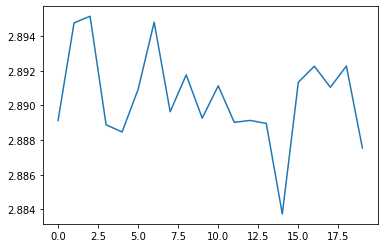

In [277]:
plt.plot(all_losses)

### 2.2 原始的RNN模型改成nn.GRU

In [247]:
rnn_GRU = nn.GRU(n_letters, n_hidden,1) 

In [248]:
learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn

def train_GRU(category_tensor, line_tensor):      #输入类别向量； 姓名的词向量

    rnn_GRU.zero_grad()
    
    input = line_tensor                         # input (seq , batch_size , inp_dim )        
    output, hidden = rnn_GRU(input)    # output (seq , batch_size , 128维 )
    
    for i in range(output.size()[0]):
        output_1 = output[i] 
        output_2 = i2o(output_1)
        output_3 = softmax(output_2)
   
    loss = criterion(output_3, category_tensor)      
    loss.backward(retain_graph=True)

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn_GRU.parameters():
        p.data.add_(-learning_rate, p.grad.data)

    return output_3, loss.item()

In [249]:
criterion = nn.CrossEntropyLoss()  

In [250]:
import time
import math

n_iters = 10000 # 训练轮次
print_every = 1000
plot_every = 500

# Keep track of losses for plotting
current_loss = 0
all_losses = []

i2o = nn.Linear(128, 18)
softmax = nn.LogSoftmax(dim=1)                         #log 输出小于0 dim=1代表对第二维的数据操作

def time_since(since):           #输出计算时间
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)
start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = sample_trainning()    
    output, loss = train_GRU(category_tensor, line_tensor)                                   
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = category_from_output(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, time_since(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

1000 10% (0m 5s) 2.8868 Segal / Czech ✗ (French)
2000 20% (0m 11s) 2.8917 Chrysanthopoulos / Czech ✗ (Greek)
3000 30% (0m 17s) 2.9249 Mohan / Czech ✗ (Irish)
4000 40% (0m 23s) 2.9269 Quyen / Czech ✗ (Vietnamese)
5000 50% (0m 29s) 2.8479 Tadhgan / Czech ✗ (Irish)
6000 60% (0m 35s) 2.8872 Sha / Czech ✗ (Chinese)
7000 70% (0m 41s) 2.9423 Trang / Irish ✗ (Vietnamese)
8000 80% (0m 46s) 2.7796 Paszek / Polish ✓
9000 90% (0m 52s) 2.7432 Damhain / Irish ✓
10000 100% (0m 59s) 2.7438 Nowak / Polish ✓


In [251]:
%matplotlib inline

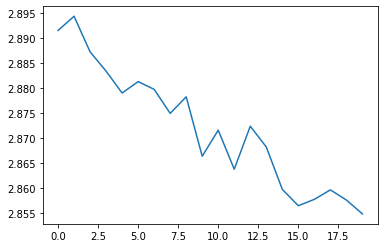

In [252]:
plt.plot(all_losses)

#### 结果对比

LSTM与GRU相比于原始RNN，训练时间更长，loss更高且波动更大

### 3.RNN模型变成多层RNN模型

In [254]:
rnn_n = nn.RNN(n_letters, n_hidden, 2) 

In [255]:
learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn

def train_n(category_tensor, line_tensor):      #输入类别向量； 姓名的词向量

    rnn_n.zero_grad()
    input = line_tensor    
    output, hidden = rnn_n(input) 

    for i in range(output.size()[0]):
        output_1 = output[i] 
        output_2 = i2o(output_1)
        output_3 = softmax(output_2)
   
    loss = criterion(output_3, category_tensor)      
    loss.backward(retain_graph=True)

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn_n.parameters():
        p.data.add_(-learning_rate, p.grad.data)

    return output_3, loss.item()

In [256]:
criterion = nn.CrossEntropyLoss() 

In [257]:
import time
import math

n_iters = 10000 # 训练轮次
print_every = 1000
plot_every = 500

# Keep track of losses for plotting
current_loss = 0
all_losses = []

i2o = nn.Linear(128, 18)
softmax = nn.LogSoftmax(dim=1)                         #log 输出小于0 dim=1代表对第二维的数据操作

def time_since(since):           #输出计算时间
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)
start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = sample_trainning()    
    output, loss = train_n(category_tensor, line_tensor)                                   
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = category_from_output(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, time_since(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

1000 10% (0m 6s) 2.9969 Kneller / Russian ✗ (German)
2000 20% (0m 12s) 3.0174 Zimmermann / Russian ✗ (German)
3000 30% (0m 18s) 2.7123 Chi / Korean ✗ (Chinese)
4000 40% (0m 24s) 2.6319 Maille / Arabic ✗ (Irish)
5000 50% (0m 30s) 2.0774 Pho / Korean ✗ (Vietnamese)
6000 60% (0m 35s) 2.4438 Ajello / Spanish ✗ (Italian)
7000 70% (0m 40s) 2.2466 Bekyros / Greek ✓
8000 80% (0m 46s) 1.6844 Seo / Chinese ✗ (Korean)
9000 90% (0m 51s) 2.7977 Hamacho / Portuguese ✗ (Japanese)
10000 100% (0m 57s) 1.6259 Gu / Korean ✓


In [258]:
%matplotlib inline

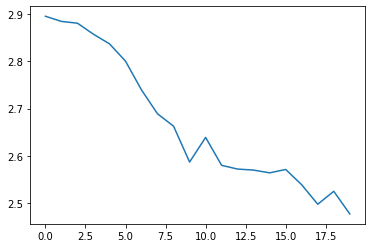

In [259]:
plt.plot(all_losses)

#### 结果对比

多层RNN与单层RNN相比，运行时间更长，loss更小

### 4.nn.NLLLoss来代替crossentropy

In [261]:
# 构建rnn
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        # 对继承自父类的属性进行初始化
        super(RNN, self).__init__()
        
        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        # torch.cat是将两个张量（tensor）拼接在一起，0为行，1为列
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128

In [262]:
rnn = RNN(n_letters, n_hidden, n_categories)

In [263]:
criterion = nn.NLLLoss()

In [264]:
learning_rate = 0.005 
# 学习率过大会爆炸，过小会消失

def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()
    
    # 梯度置零
    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn.forward(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(-learning_rate, p.grad.data)

    return output, loss.item()

In [265]:
import time
import math

n_iters = 10000 # 这个数字你可以调大一些
print_every = 1000
plot_every = 500


# 记录损失用于绘图
current_loss = 0
all_losses = []

# 运行时间
def time_since(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = sample_trainning()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = category_from_output(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, time_since(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

1000 10% (0m 2s) 2.9561 Pei / Italian ✗ (Chinese)
2000 20% (0m 5s) 2.9651 Sokal / Scottish ✗ (Polish)
3000 30% (0m 8s) 2.8733 Qureshi / Polish ✗ (Arabic)
4000 40% (0m 11s) 2.4436 Fujimaki / Polish ✗ (Japanese)
5000 50% (0m 13s) 2.3055 Shon / Chinese ✗ (Korean)
6000 60% (0m 16s) 1.9080 Bui / Chinese ✗ (Vietnamese)
7000 70% (0m 19s) 1.9706 Nahas / Arabic ✓
8000 80% (0m 22s) 2.7237 Jordan / Irish ✗ (Polish)
9000 90% (0m 25s) 0.2359 Giannakos / Greek ✓
10000 100% (0m 28s) 2.1633 Bayer / Arabic ✗ (German)


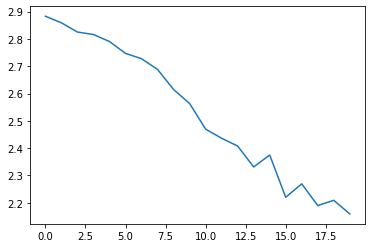

In [266]:
%matplotlib inline
plt.plot(all_losses)